In [ ]:
# tnx to deep learning preprocessing steps for speach recognition is not as vital as before
# I haven't done much preprocessing except for removing outliers and changing the sampling rate fro 16000 to 8000

In [70]:
import os
import sys
import numpy as np
import warnings
import librosa #for audio processing
import IPython. display as ipd
from keras.utils import np_utils
import matplotlib. pyplot as plt
from IPython.display import Audio
from scipy. io import wavfile #for audio processing
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from keras.layers import Dense, Dropout, Flatten, Conv1D, Input, MaxPooling1D
from keras.models import Model
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K
K.clear_session()
np.random.seed(1)

warnings. filterwarnings("ignore")

sample_r = 8000
bs = 32

snapshot_folder ='weights'

In [71]:
# showing a progressbar in output
def progressBar(value, endvalue, bar_length=20,job='Job'):

    percent = float(value) / endvalue
    arrow = '-' * int(round(percent * bar_length)-1) + '>'
    spaces = ' ' * (bar_length - len(arrow))

    sys.stdout.write("\r{0} Completion: [{1}] {2}%".format(job,arrow + spaces, int(round(percent * 100))))
    sys.stdout.flush()

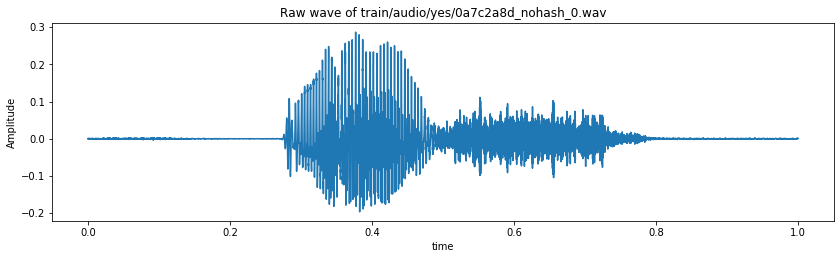

In [72]:
train_audio_path = 'train/audio/'
samples, sample_rate = librosa. load(train_audio_path+'yes/0a7c2a8d_nohash_0.wav' , sr = 16000)
fig = plt. figure(figsize=(14, 8))
ax1 = fig. add_subplot(211)
ax1. set_title('Raw wave of ' + 'train/audio/yes/0a7c2a8d_nohash_0.wav' )
ax1. set_xlabel('time' )
ax1. set_ylabel('Amplitude' )
ax1. plot(np. linspace(0, sample_rate/len(samples), sample_rate), samples)

In [18]:
# playing the track in 16000Hz
sound_file = train_audio_path+'yes/0a7c2a8d_nohash_0.wav'
Audio(sound_file)

In [4]:
ipd.Audio(samples, rate=sample_rate)
print(sample_rate)

16000


In [9]:
# From the above, we can understand that the sampling rate of the signal is 16,000 Hz. Let us re-sample it to
# 8000 Hz since most of the speech-related frequencies are present at 8000 Hz
samples = librosa.resample(samples, sample_rate, sample_r)
ipd.Audio(samples, rate=sample_r)

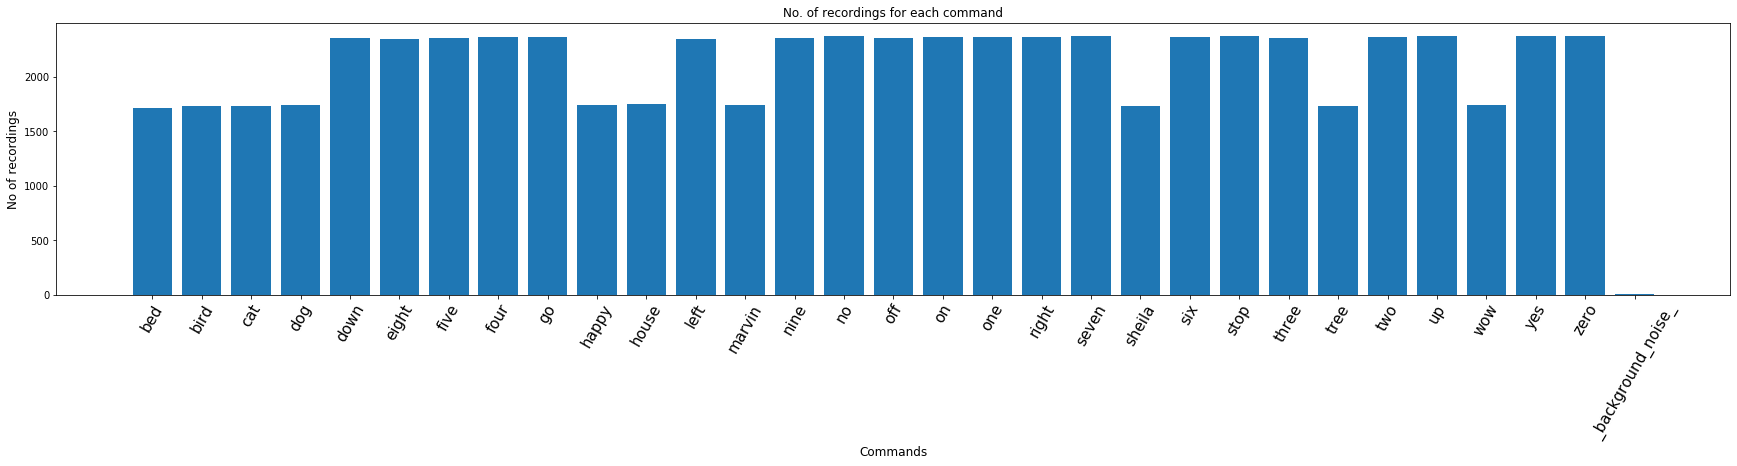

In [20]:
labels=os. listdir(train_audio_path)
#find count of each label and plot bar graph
no_of_recordings=[]
for label in labels:
    waves = [ f for f in os. listdir(train_audio_path + '/' + label) if f. endswith('.wav' )]
    no_of_recordings. append(len(waves))

# ploting the class distribution
plt. figure(figsize=(30, 5))
index = np. arange(len(labels))
plt. bar(index, no_of_recordings)
plt. xlabel('Commands' , fontsize=12)
plt. ylabel('No of recordings' , fontsize=12)
plt. xticks(index, labels, fontsize=15, rotation=60)
plt. title('No. of recordings for each command' )
plt. show()
labels=[ "yes", "no", "up", "down", "left", "right", "on", "off", "stop", "go"]

(array([1.5000e+01, 3.0000e+01, 4.4000e+01, 1.3800e+02, 1.3600e+02,
        1.7900e+02, 3.6600e+02, 4.3400e+02, 5.9300e+02, 2.1747e+04]),
 array([0.418 , 0.4762, 0.5344, 0.5926, 0.6508, 0.709 , 0.7672, 0.8254,
        0.8836, 0.9418, 1.    ]),
 <a list of 10 Patch objects>)

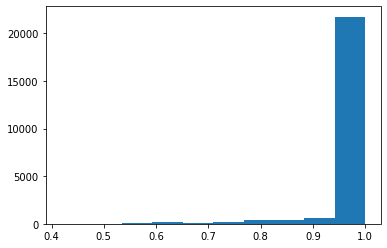

In [21]:
# calculating track durations
duration_of_recordings=[]
for label in labels:
    waves = [ f for f in os. listdir(train_audio_path + '/' + label) if f. endswith('.wav' )]
    for wav in waves:
        sample_rate, samples = wavfile. read(train_audio_path + '/' + label + '/' + wav)
        duration_of_recordings.append(float(len(samples) /sample_rate))

len_train = len(duration_of_recordings)
plt.title('Durations')
plt.hist(np.array(duration_of_recordings))

Here are the two steps we’ll follow:

Resampling,
Removing shorter commands of less than 1 second

In [68]:
os.listdir(train_audio_path)

['bed',
 'bird',
 'cat',
 'dog',
 'down',
 'eight',
 'five',
 'four',
 'go',
 'happy',
 'house',
 'left',
 'marvin',
 'nine',
 'no',
 'off',
 'on',
 'one',
 'right',
 'seven',
 'sheila',
 'six',
 'stop',
 'three',
 'tree',
 'two',
 'up',
 'wow',
 'yes',
 'zero',
 '_background_noise_']

In [ ]:
def read_data(path):
    i =0 
    all_wave = []
    all_label = []
    for label in labels:
        i+=1
        progressBar(i, len(labels), bar_length=20,job='Resampling, Removing shorter commands')
        waves = [f for f in os.listdir(path + '/'+ label) if f.endswith('.wav')]
        for wav in waves:
            samples, sample_rate = librosa.load(path + '/' + label + '/' + wav, sr = 16000)
            samples = librosa.resample(samples, sample_rate, sample_r)
            if(len(samples)== sample_r) : 
                all_wave.append(samples)
                all_label.append(label)
                
    return all_wave, all_label

all_wave, all_label = read_data(train_audio_path)

In [ ]:
le = LabelEncoder()
y=le.fit_transform(all_label)
classes= list(le.classes_)
classes

In [44]:
y=np_utils.to_categorical(y, num_classes=len(labels))

In [46]:
# Split into train and validation set
x_tr, x_val, y_tr, y_val = train_test_split(np.array(all_wave),np.array(y),
                                            stratify=y, test_size = 0.2, random_state=1, shuffle=True)

In [47]:
# Reshape the 2D array to 3D since the input to the conv1d must be a 3D array
x_tr = np.array(x_tr).reshape(-1,sample_r,1)
x_val = np.array(x_val).reshape(-1,sample_r,1)

### model

We will build the speech-to-text model using conv1d

In [50]:
def make_model():
    inputs = Input(shape=(sample_r,1))

    #First Conv1D layer
    conv = Conv1D(8,13, padding='valid', activation='relu', strides=1)(inputs)
    conv = MaxPooling1D(3)(conv)
    conv = Dropout(0.3)(conv)

    #Second Conv1D layer
    conv = Conv1D(16, 11, padding='valid', activation='relu', strides=1)(conv)
    conv = MaxPooling1D(3)(conv)
    conv = Dropout(0.3)(conv)

    #Third Conv1D layer
    conv = Conv1D(32, 9, padding='valid', activation='relu', strides=1)(conv)
    conv = MaxPooling1D(3)(conv)
    conv = Dropout(0.3)(conv)

    #Fourth Conv1D layer
    conv = Conv1D(64, 7, padding='valid', activation='relu', strides=1)(conv)
    conv = MaxPooling1D(3)(conv)
    conv = Dropout(0.3)(conv)

    #Flatten layer
    conv = Flatten()(conv)

    #Dense Layer 1
    conv = Dense(256, activation='relu')(conv)
    conv = Dropout(0.3)(conv)

    #Dense Layer 2
    conv = Dense(128, activation='relu')(conv)
    conv = Dropout(0.3)(conv)

    outputs = Dense(len(labels), activation='softmax')(conv)

    model = Model(inputs, outputs)
    model.summary()
    return model

In [57]:
model = make_model()
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 8000, 1)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 7988, 8)           112       
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 2662, 8)           0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 2662, 8)           0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 2652, 16)          1424      
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 884, 16)           0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 884, 16)           0         
__________

In [58]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=30, min_delta=0.0001) 
mc = ModelCheckpoint(snapshot_folder+'/best_model.hdf5', monitor='val_acc', verbose=1, save_best_only=True, mode='max')

In [ ]:
history= model.fit(x_tr, y_tr ,epochs=100, callbacks=[es,mc], batch_size=bs, validation_data=(x_val,y_val))

In [ ]:
from matplotlib import pyplot as plt
plt.plot(history.history['loss'], label='train') 
plt.plot(history.history['val_loss'], label='test') 
plt.legend() 
plt.show()

In [62]:
def predict(audio):
    prob=model.predict(audio.reshape(1,sample_r,1))
    index=np.argmax(prob[0])
    return classes[index]

In [ ]:
import random
index=random.randint(0,len(x_val)-1)
samples=x_val[index].ravel()
print("Audio:",classes[np.argmax(y_val[index])])
ipd.Audio(samples, rate=sample_r)
print("Text:",predict(samples))

In [64]:
import sounddevice as sd
import soundfile as sf

samplerate = 16000  
duration = 1 # seconds
filename = 'yes.wav'
print("start")
mydata = sd.rec(int(samplerate * duration), samplerate=samplerate,
    channels=1, blocking=True)
print("end")
sd.wait()
sf.write(filename, mydata, samplerate)

start
end


In [ ]:
os.listdir('../input/voice-commands/prateek_voice_v2')
filepath='../input/voice-commands/prateek_voice_v2'

#reading the voice commands
samples, sample_rate = librosa.load(filepath + '/' + 'stop.wav', sr = 16000)
samples = librosa.resample(samples, sample_rate, 8000)
ipd.Audio(samples,rate=8000)  

predict(samples)